# MDD - data creation

In this notebook we create a synthetic 3D dataset to test multi-dimensional convolution/deconvolution

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import shutil
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import dask.array as da
import zarr

from numcodecs import Blosc

from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.tapers               import *

Choose number of chunks used to divide frequency axis of the kernel

In [2]:
nchunks = 4

Set env variable with path

In [3]:
os.environ["STORE_PATH"] = "/project/fsenter/mrava/MDD3D/"

##  Data creation

In [4]:
#shutil.rmtree(os.environ["STORE_PATH"]+'/m.zarr')
#shutil.rmtree(os.environ["STORE_PATH"]+'/mwav.zarr')
#shutil.rmtree(os.environ["STORE_PATH"]+'/K.zarr')

In [5]:
###### Input parameters
par = {'ox':-300, 'dx':20,    'nx':31,
       'oy':-200, 'dy':20,    'ny':21,
       'ot':0,    'dt':0.004, 'nt':250,
       'f0': 20,  'nfmax': 200}

t0_m    = [0.2]
vrms_m  = [2400.]
amp_m   = [1.]

t0_G    = [0.1, 0.2, 0.4]
vrms_G  = [1600.,1800., 2000.]
amp_G   = [1.,0.6,0.5]

# Create axis
t,t2,x,y = makeaxis(par)

# Create wavelet
wav = ricker(t[:41], f0=par['f0'])[0]

Test creating data

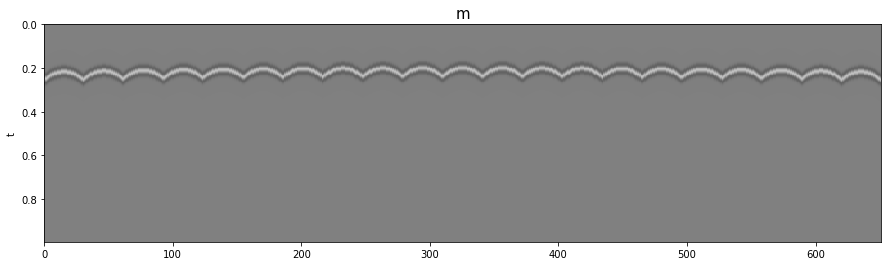

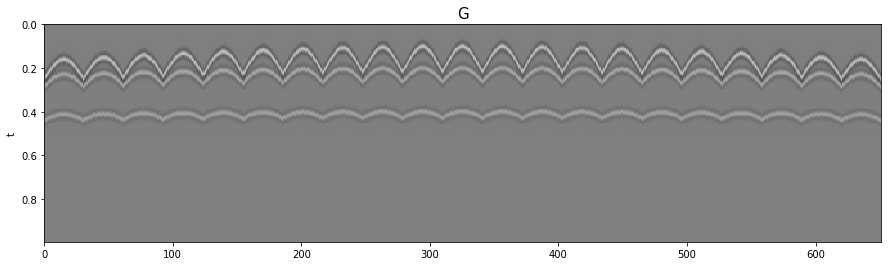

In [6]:
y0, x0 = y[par['ny']//2], x[par['nx']//2]

m, mwav = hyperbolic3d(x, y, t, t0_m, vrms_m, vrms_m, amp_m, wav)
_, Kwav = hyperbolic3d(x-x0, y-y0, t, t0_G, vrms_G, vrms_G, amp_G, wav)
    
plt.figure(figsize=(15, 4))
plt.imshow(mwav.reshape(par['ny']*par['nx'], par['nt']).T, aspect='auto',
           interpolation='nearest', vmin=-2, vmax=2, cmap='gray',
           extent=(0, par['ny']*par['nx'], t.max(), t.min()))
plt.title('m', fontsize=15)
plt.ylabel('t');

plt.figure(figsize=(15, 4))
plt.imshow(Kwav.reshape(par['ny']*par['nx'], par['nt']).T, aspect='auto',
           interpolation='nearest', vmin=-2, vmax=2, cmap='gray',
           extent=(0, par['ny']*par['nx'], t.max(), t.min()))
plt.title('G', fontsize=15)
plt.ylabel('t');

Create model

In [7]:
# Generate model
m, mwav = hyperbolic3d(x, y, t, t0_m, vrms_m, vrms_m, amp_m, wav)
m = m.reshape(par['ny']*par['nx'], par['nt'])
m  = np.concatenate((np.zeros((par['ny']*par['nx'], par['nt']-1)), m), axis=-1)
mwav = mwav.reshape(par['ny']*par['nx'], par['nt'])
mwav  = np.concatenate((np.zeros((par['ny']*par['nx'], par['nt']-1)), mwav), axis=-1)

# Save in zarr file
mstore = zarr.DirectoryStore(os.environ["STORE_PATH"]+'/m.zarr')
mzaar = zarr.create(store=mstore, overwrite=True, 
                    shape=(2*par['nt']-1, par['ny']*par['nx']), 
                    chunks=(2*par['nt']-1, par['ny']*par['nx']), 
                    dtype=np.float32)

mwavstore = zarr.DirectoryStore(os.environ["STORE_PATH"]+'/mwav.zarr')
mwavzaar = zarr.create(store=mwavstore, overwrite=True, 
                       shape=(2*par['nt']-1, par['ny']*par['nx']), 
                       chunks=(2*par['nt']-1, par['ny']*par['nx']), 
                       dtype=np.float32)

In [8]:
mzaar.info

Type,zarr.core.Array
Data type,float32
Shape,"(499, 651)"
Chunk shape,"(499, 651)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,1299396 (1.2M)
No. bytes stored,341
Storage ratio,3810.5


Let's write inside

In [9]:
mzaar[:, :] = m.T
mwavzaar[:, :] = mwav.T

Kernel generation

In [10]:
#compressor = Blosc(cname='zstd', clevel=3, shuffle=Blosc.BITSHUFFLE)

Kstore = zarr.DirectoryStore(os.environ["STORE_PATH"]+'/K.zarr')
Kzaar = zarr.create(store=Kstore, overwrite=True, 
                    shape=(par['nfmax'], par['ny']*par['nx'], par['ny']*par['nx']), 
                    chunks=(par['nfmax'] // nchunks, par['ny']*par['nx'], par['ny']*par['nx']), 
                    dtype=np.complex64)#, compressor=compressor)

In [11]:
Kzaar.info

Type,zarr.core.Array
Data type,complex64
Shape,"(200, 651, 651)"
Chunk shape,"(50, 651, 651)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,678081600 (646.7M)
No. bytes stored,395
Storage ratio,1716662.3


In [12]:
df = 5
ifs = np.arange(0, par['nfmax'] // df) * df
ifs = np.append(ifs, par['nfmax'])

for iy, y0 in enumerate(y):
    print('Working on %d/%d' %(iy, par['ny']))
    Kwavy = np.zeros((par['nfmax'], par['nx'], par['nx']*par['ny']), dtype=np.complex128)
    for ix, x0 in enumerate(x):
        _, Kwavtmp = hyperbolic3d(x-x0, y-y0, t, t0_G, vrms_G, vrms_G, amp_G, wav)
        Kwavtmp = Kwavtmp.reshape(par['ny']*par['nx'], par['nt'])
        Kwavtmp = np.concatenate((np.zeros((par['ny']*par['nx'], par['nt']-1)), Kwavtmp), axis=-1)
        Kwavtmp = np.fft.rfft(Kwavtmp, 2*par['nt']-1, axis=-1)
        Kwavtmp = Kwavtmp[..., :par['nfmax']]
        Kwavy[:, ix] =  Kwavtmp.T
    for i in range(len(ifs)-1):
        Kzaar[ifs[i]:ifs[i+1], iy*par['nx']:(iy+1)*par['nx'], :] = Kwavy[ifs[i]:ifs[i+1]]

Working on 0/21
Working on 1/21
Working on 2/21
Working on 3/21
Working on 4/21
Working on 5/21
Working on 6/21
Working on 7/21
Working on 8/21
Working on 9/21
Working on 10/21
Working on 11/21
Working on 12/21
Working on 13/21
Working on 14/21
Working on 15/21
Working on 16/21
Working on 17/21
Working on 18/21
Working on 19/21
Working on 20/21


G = np.zeros((par['ny']*par['nx'], par['ny']*par['nx'], par['nt']))
Gwav = np.zeros((par['ny']*par['nx'], par['ny']*par['nx'], par['nt']))
for iy, y0 in enumerate(y):
    for ix, x0 in enumerate(x):
        Ghyp, Gwavhyp = hyperbolic3d(x-x0, y-y0, t, t0_G, vrms_G, vrms_G, amp_G, wav)
        G[iy*par['nx'] + ix] = Ghyp.reshape(par['ny']*par['nx'], par['nt']) 
        Gwav[iy*par['nx'] + ix] = Gwavhyp.reshape(par['ny']*par['nx'], par['nt'])
Gwav2 = np.concatenate((np.zeros((par['ny']*par['nx'], par['ny']*par['nx'], par['nt']-1)), Gwav), axis=-1)
Gwav2 = np.fft.rfft(Gwav2, 2*par['nt']-1, axis=-1)
Gwav2 = Gwav2[...,:par['nfmax']]
Gwav2 = Gwav2.transpose(2,0,1)

K = da.from_zarr(os.environ["STORE_PATH"]+'/K.zarr')

print((da.sum(K-Gwav2)).compute())

In [13]:
Kzaar.info

Type,zarr.core.Array
Data type,complex64
Shape,"(200, 651, 651)"
Chunk shape,"(50, 651, 651)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,678081600 (646.7M)
No. bytes stored,91374778 (87.1M)
Storage ratio,7.4
